In [3]:
import csv
import datetime
import datalab.bigquery as bq
import google.datalab.storage as storage
import io
import logging
import math as m
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import scipy.stats as stats
import seaborn as sns
import statsmodels.sandbox.stats.multicomp as multicomp
import time

#### Set up logging

In [4]:
logger = logging.getLogger()

In [5]:
def setup_file_logger(log_file):
    for handler in logger.handlers[:]:
        logger.removeHandler(handler)
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    
def log(message):
  print(message)
  logger.info(message)

setup_file_logger('mirtar.log')

## Function definitions

#### Utils

In [6]:
def read_file(bucket, filepath, **kwargs):
  uri = bucket.object(filepath).uri
  get_ipython().run_line_magic('gcs', 'read --object ' + uri + ' --variable csv_data')
  return pd.read_csv(io.BytesIO(csv_data), **kwargs)

In [7]:
def write_df_to_csv(df, index_label, csv_filepath):
  df.to_csv('temp.csv', index_label = index_label)
  !gsutil cp 'temp.csv' $csv_filepath

In [8]:
def save_as(temp_filename, filepath):
  !gsutil cp $temp_filename $filepath

In [9]:
def get_corrs_df(bucket, filepath, index_col):
  df = read_file(bucket, filepath)
  df.set_index(index_col, inplace=True)
  return df

#### Analysis

In [10]:
def get_rank_indices(df, ranks):
  df_flattened = df.values.flatten()
  df_flattened_argsorted = np.argsort(df_flattened)
  df_flattened_sorted_nan_idxs = np.where(np.isnan(np.sort(df_flattened)))[0]
  if df_flattened_sorted_nan_idxs.size > 0:
    df_flattened_argsorted = df_flattened_argsorted[:df_flattened_sorted_nan_idxs[0]]
  return zip(map(lambda i: df.index[df_flattened_argsorted[i] / df.shape[1]], ranks), map(lambda i: df.columns[df_flattened_argsorted[i] % df.shape[1]], ranks))

#### Plotting

In [11]:
def heatmap(data, title, xlab, ylab, xticks, yticks, xticklabels, yticklabels, xsz, ysz, cmap, **kwargs):
    fig, ax = plt.subplots()
    if 'label_fontsize' in kwargs:
        ax.set_title(title, fontsize=kwargs['label_fontsize'])
        ax.set_xlabel(xlab, fontsize=kwargs['label_fontsize'])
        ax.set_ylabel(ylab, fontsize=kwargs['label_fontsize'])
    else:
        ax.set_title(title)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    xticklab_dict = dict()
    if ('xticklabels_rotation' in kwargs):
        xticklab_dict['rotation'] = kwargs['xticklabels_rotation']
    if ('ha' in kwargs):
        xticklab_dict['ha'] = kwargs['ha']
    ax.set_xticklabels(xticklabels, xticklab_dict)
    if 'va' in kwargs:
        ax.set_yticklabels(yticklabels, va=kwargs['va'])
    else:
        ax.set_yticklabels(yticklabels)
    fig.set_size_inches(xsz, ysz)
    heatmap = ax.pcolormesh(data, cmap=cmap)
    fig.colorbar(heatmap, ax=ax)
    return fig

In [12]:
# I'd use sns.scatterplot but it's not in version 0.7.0, and I didn't have time to upgrade...
def scatterplot(data, title, x, y, alpha):
    fgrid = sns.lmplot(x, y, data=data, hue='Disease', fit_reg=False, scatter_kws=dict(alpha=alpha))
    fgrid.fig.suptitle(title)
    fgrid.fig.set_size_inches(15, 12)
    return fgrid.fig

In [13]:
def histogram(data, xsz, ysz, title, xlab):
    fig, ax = plt.subplots()
    sns.distplot(data, ax=ax)
    fig = ax.get_figure()
    fig.set_size_inches(xsz, ysz)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    return fig

In [14]:
# this is put through some abuse below (ranks requested not adjusting size/indices for null values), which I haven't been compelled to rectify
def corr_scatterplots(corrs_df, corr_ranks, data, alpha, ranks_for_title, corrtype, filepath, cancer_type=''):
  indices = get_rank_indices(corrs_df, corr_ranks)
  for i in range(len(corr_ranks)):
    x, y = indices[i]
    title = ranks_for_title[i] + ' MiRTar ' + corrtype + ' correlation (' + str(corrs_df.loc[x, y]) + ')'
    prefix = filepath + str(ranks[i]) + '_' + y + '-vs-' + x + '-' + corrtype + '-corrs'
    if cancer_type:
      title += 'in ' + cancer_type
      prefix += '_' + cancer_type
    title += ': log-transformed ' + y + ' expression vs ' + x + ' expression'
    prefix += '_scatter.png'
    scatterplot(data, title, x, y, alpha).savefig('temp.png')
    save_as('temp.png', prefix)

In [15]:
def per_cancer_type_histograms(cancer_type, mirtar_corrs, mirtar_log_corrs, mirtar_spearman_corrs, mirtar_spearman_corrs_5pct, xsz, ysz, mrna_or_target, prefix, title_suffix=''):
    title = 'Histogram: miRNA-' + mrna_or_target + ' expression Pearson correlations in ' + cancer_type + ' samples' + title_suffix
    histogram(mirtar_corrs, xsz, ysz, title, 'Correlation').savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/' + prefix + '-corrs_' + cancer_type + '_histogram.png')
    title = 'Histogram: Pearson correlations of log-transformed miRNA & ' + mrna_or_target + ' expression in ' + cancer_type + ' samples' + title_suffix
    histogram(mirtar_log_corrs, xsz, ysz, title, 'Correlation').savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/' + prefix + '-log-corrs_' + cancer_type + '_histogram.png')
    title = 'Histogram: miRNA-' + mrna_or_target + ' expression Spearman correlations in ' + cancer_type + ' samples' + title_suffix
    histogram(mirtar_spearman_corrs, xsz, ysz, title, 'Correlation').savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/' + prefix + '-spearman-corrs_' + cancer_type + '_histogram.png')
    title = 'Histogram: miRNA-' + mrna_or_target + ' expression Spearman correlations in ' + cancer_type + ' samples, 5% significance' + title_suffix
    histogram(mirtar_spearman_corrs_5pct, xsz, ysz, title, 'Correlation').savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/' + prefix + '-spearman-corrs-5pct_' + cancer_type + '_histogram.png')

In [16]:
def per_cancer_type_heatmaps(cancer_type, mirtar_corrs, mirtar_log_corrs, mirtar_spearman_corrs, xsz, ysz, label_fontsize):
    mirtar_corrs['corr_10th-pctl'] = mirtar_corrs.quantile(0.1, axis=1)
    title = 'miRNA-mRNA expression correlations in ' + cancer_type + ', missing values in white: miRNAs sorted by 10th percentile of correlations (values restricted to [-0.2, 0.2])'
    heatmap(mirtar_corrs.sort_values('corr_10th-pctl').applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x), title, 'mRNA', 'miRNA',
            np.arange(mirtar_corrs.shape[1]), np.arange(mirtar_corrs.shape[0]), [], [], xsz, ysz, 'cubehelix', label_fontsize=label_fontsize).savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRNAmRNA-corrs_' + cancer_type + '_heatmap.png')
    del mirtar_corrs['corr_10th-pctl']
    mirtar_log_corrs['corr_10th-pctl'] = mirtar_log_corrs.quantile(0.1, axis=1)
    title = 'log-transformed miRNA-mRNA expression correlations in ' + cancer_type + ', missing values in white: miRNAs sorted by 10th percentile of correlations (values restricted to [-0.2, 0.2])'
    heatmap(mirtar_log_corrs.sort_values('corr_10th-pctl').applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x), title, 'mRNA', 'miRNA',
            np.arange(mirtar_log_corrs.shape[1]), np.arange(mirtar_log_corrs.shape[0]), [], [], xsz, ysz, 'cubehelix', label_fontsize=label_fontsize).savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRNAmRNA-log-corrs_' + cancer_type + '_heatmap.png')
    del mirtar_log_corrs['corr_10th-pctl']
    # Spearman corrs
    mirtar_spearman_corrs['corr_10th-pctl'] = mirtar_spearman_corrs.quantile(0.1, axis=1)
    title = 'miRNA-target (mRNA) expression Spearman correlations in ' + cancer_type + ', missing values in white: miRNAs sorted by 10th percentile of correlations'
    heatmap(mirtar_spearman_corrs.sort_values('corr_10th-pctl').applymap(lambda x: 0.4 if x > 0.4 else -0.4 if x < -0.4 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_spearman_corrs.shape[1]), np.arange(mirtar_spearman_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
    save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRNAmRNA-spearman-corrs_' + cancer_type + '_heatmap.png')
    del mirtar_spearman_corrs['corr_10th-pctl']

In [17]:
def per_cancer_type_corr_scatterplots(cancer_type, mirtar_corrs, mirtar_log_corrs, mirtar_spearman_corrs, samples):
    corr_scatterplots(mirtar_corrs, [0, (mirtar_corrs.shape[0] * mirtar_corrs.shape[1]) / 2, -1], samples, 0.2, ['Smallest', 'Median', 'Largest'], '',
                      'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-corr', cancer_type)
    corr_scatterplots(mirtar_log_corrs, [0, (mirtar_log_corrs.shape[0] * mirtar_log_corrs.shape[1]) / 2, -1], samples, 0.2, ['Smallest', 'Median', 'Largest'], '',
                      'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-log-corr', cancer_type)
    corr_scatterplots(mirtar_spearman_corrs, [0, (mirtar_spearman_corrs.shape[0] * mirtar_spearman_corrs.shape[1]) / 2, -1], samples, 0.2, ['Smallest', 'Median', 'Largest'],
                      'Spearman', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/scatter/miRNAmRNA-spearman-corr', cancer_type)

## Data: Preliminaries

In [18]:
bucket = storage.Bucket('yfl-mirna')

### Correlation data

#### Across all samples

In [19]:
mirtar_corrs = read_file(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-corrs.csv')
mirtar_corrs.set_index('miRNA', inplace=True)
mirtar_corrs_np = mirtar_corrs.values

In [20]:
mirtar_corrs.shape

(743, 16335)

In [21]:
mirtar_log_corrs = read_file(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-log-corrs.csv')
mirtar_log_corrs.set_index('miRNA', inplace=True)
mirtar_log_corrs_np = mirtar_log_corrs.values

In [22]:
mirtar_spearman_corrs = read_file(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs.csv')
mirtar_spearman_corrs.set_index('miRNA', inplace=True)
mirtar_spearman_corrs_np = mirtar_spearman_corrs.values

In [23]:
mirtar_spearman_corr_pvals = read_file(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corr-pvals.csv')
mirtar_spearman_corr_pvals.set_index('miRNA', inplace=True)

In [24]:
mirtar_spearman_corrs_5pct = mirtar_spearman_corrs.mask(mirtar_spearman_corr_pvals > 0.05, np.nan)
mirtar_spearman_corrs_5pct_np = mirtar_spearman_corrs_5pct.values

### miRNA data

#### Read sample miRNA expression data

In [25]:
miRNA_data = read_file(bucket, 'data/miRNA/pancanMiRs_EBadjOnProtocolPlatformWithoutRepsWithUnCorrectMiRs_08_04_16.csv')

In [26]:
miRNA_data.rename(index=str, columns={'Genes': 'miRNA'}, inplace=True)
miRNA_data.set_index('miRNA', inplace=True)
miRNA_data['Corrected'] = (miRNA_data['Correction'] == 'Corrected')
del miRNA_data['Correction']

In [27]:
miRNA_corrections = pd.DataFrame(miRNA_data[['Corrected']])
del miRNA_data['Corrected']

In [28]:
miRNA_data.index.unique().size == miRNA_data.shape[0]

True

#### Transpose miRNA_data to get samples as rows

In [29]:
sample_miRNAs = miRNA_data.T
sample_miRNAs.index = sample_miRNAs.index.map(lambda x: '-'.join(x.split('-')[0:4]))
sample_miRNAs.reset_index(inplace=True)
sample_miRNAs.drop_duplicates(subset='index', keep='first', inplace=True)
sample_miRNAs.set_index('index', inplace=True)

In [30]:
miRNAs_num = len(sample_miRNAs.columns)

### mRNA data

#### Read sample mRNA expression data

In [29]:
mRNA_data = read_file(bucket, 'data/mRNA/EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', delimiter='\t')

In [30]:
mRNA_data.rename(index=str, columns={'gene_id': 'mRNA'}, inplace=True)
mRNA_data.set_index('mRNA', inplace=True)

In [31]:
mRNA_data['entrezID'] = mRNA_data.index.map(lambda x: x.split('|')[1])
mRNA_data.set_index('entrezID', inplace=True)

#### Transpose mRNA_data to get samples as rows

In [32]:
sample_mRNAs = mRNA_data.T
sample_mRNAs.index = sample_mRNAs.index.map(lambda x: '-'.join(x.split('-')[0:4]))
sample_mRNAs.reset_index(inplace=True)
sample_mRNAs.drop_duplicates(subset='index', keep='first', inplace=True)
sample_mRNAs.set_index('index', inplace=True)

### miRTarBase data

In [31]:
mirtar_data = read_file(bucket, 'data/miRTar/miRTarBase_MTI.csv', encoding='ISO-8859-1')

In [32]:
colnames_from_to = { 'miRTarBase ID': 'mirtarbaseID', 'Species (miRNA)': 'miRNA_species', 'Target Gene': 'targetID',
                     'Target Gene (Entrez ID)': 'target_entrezID', 'Species (Target Gene)': 'target_species',
                     'Support Type': 'support_type', 'References (PMID)': 'PMID_references' }
mirtar_data.rename(columns=colnames_from_to, inplace=True)
mirtar_data = mirtar_data[mirtar_data.target_species == 'Homo sapiens']

#### Compute fraction of entries for each miRTar pair reporting not-weak evidence of targeting

In [33]:
mirtar_data['support_type_strong'] = mirtar_data.support_type.apply(lambda x: 0 if re.search(r'Weak', x) else 1)

In [34]:
mirtar_support_type_strong_counts = mirtar_data.groupby(['miRNA', 'target_entrezID'])['support_type_strong'].sum()
mirtar_entry_counts = mirtar_data.groupby(['miRNA', 'target_entrezID']).size()
mirtar_support_type_strong_fractions = (mirtar_support_type_strong_counts / mirtar_entry_counts).unstack()
mirtar_support_type_strong_fractions.columns = mirtar_support_type_strong_fractions.columns.map(lambda col: str(col))

In [35]:
del mirtar_data['support_type_strong']
mirtar_data.set_index('miRNA', inplace=True)

### Definitions

In [ ]:
type1_sample_disease_mirtars = read_file(bucket, 'data/miRTar/type1-sample_disease_miRNAmRNA-exprs.csv')

In [ ]:
type1_sample_disease_mirtars.set_index('sample', inplace=True)

In [ ]:
type1_sample_disease_mirtars_log = type1_sample_disease_mirtars.drop(columns=['Disease']).applymap(lambda x: m.log(x + 2, 2))
type1_sample_disease_mirtars_log['Disease'] = type1_sample_disease_mirtars.Disease

In [ ]:
sample_mirtars_log_groupedby_tumor_type = type1_sample_disease_mirtars_log.groupby('Disease')

In [ ]:
type1_mRNA_count = mRNA_data.index.size

In [ ]:
cancer_types_and_counts = type1_sample_disease_mirtars['Disease'].value_counts().sort_index()
cancer_types = cancer_types_and_counts.index

## Plots: All miRNA-mRNA correlations

### All type-1 samples

#### Histograms

In [ ]:
histogram(mirtar_corrs_np[~np.isnan(mirtar_corrs_np)], 10, 10,
          'Histogram: miRNA-mRNA expression Pearson correlations across all samples', 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRNAmRNA-corrs_histogram.png')

In [ ]:
histogram(mirtar_log_corrs_np[~np.isnan(mirtar_log_corrs_np)], 10, 10,
          'Histogram: Pearson correlations for log-transformed miRNA-mRNA expression across all samples', 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRNAmRNA-log-corrs_histogram.png')

In [ ]:
title = 'Histogram: all miRNA-mRNA expression Spearman correlations across all samples'
histogram(mirtar_spearman_corrs_np[~np.isnan(mirtar_spearman_corrs_np)], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRNAmRNA-spearman-corrs_histogram.png')

In [ ]:
title = 'Histogram: miRNA-mRNA expression Spearman correlations across all samples, 5% significance'
histogram(mirtar_spearman_corrs_5pct_np[~np.isnan(mirtar_spearman_corrs_5pct_np)], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRNAmRNA-spearman-corrs-5pct_histogram.png')

#### Heatmaps

#### Correlations

In [119]:
mirtar_corrs['corr_10th-pctl'] = mirtar_corrs.quantile(0.1, axis=1)
mirtar_corrs_sortedby_10thpctl = mirtar_corrs.sort_values('corr_10th-pctl')

In [ ]:
title = 'miRNA-mRNA expression correlations (values restricted to [-0.2, 0.2]) across all samples, miRNAs sorted by 10th percentile of correlations'
heatmap(mirtar_corrs_sortedby_10thpctl.applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_corrs.shape[1]), np.arange(mirtar_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRNAmRNA-corrs_heatmap.png')

In [ ]:
title = 'miRNA-mRNA expression correlations (values restricted to <= 0) across all samples, miRNAs sorted by 10th percentile of correlations'
heatmap(mirtar_corrs_sortedby_10thpctl.applymap(lambda x: 0 if x > 0 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_corrs.shape[1]), np.arange(mirtar_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRNAmRNA-corrs-lte0_heatmap.png')

In [120]:
del mirtar_corrs['corr_10th-pctl']
del mirtar_corrs_sortedby_10thpctl

#### Correlations in log-transformed expression

In [122]:
mirtar_log_corrs['corr_10th-pctl'] = mirtar_log_corrs.quantile(0.1, axis=1)
mirtar_log_corrs_sortedby_10thpctl = mirtar_log_corrs.sort_values('corr_10th-pctl')

In [ ]:
title = 'Correlations of log-transformed miRNA & mRNA expression across all samples, miRNAs sorted by 10th percentile of correlations (values restricted to [-0.2, 0.2])'
heatmap(mirtar_log_corrs_sortedby_10thpctl.applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_log_corrs.shape[1]), np.arange(mirtar_log_corrs.shape[0]), [], [], 24, 10, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRNAmRNA-log-corrs_heatmap.png')

In [123]:
del mirtar_log_corrs['corr_10th-pctl']
del mirtar_log_corrs_sortedby_10thpctl

#### Spearman correlations

In [124]:
mirtar_spearman_corrs['corr_10th-pctl'] = mirtar_spearman_corrs.quantile(0.1, axis=1)
mirtar_spearman_corrs_sortedby_10thpctl = mirtar_spearman_corrs.sort_values('corr_10th-pctl')

In [ ]:
title = 'miRNA-mRNA expression Spearman correlations across all samples, miRNAs sorted by 10th percentile of correlations'
heatmap(mirtar_spearman_corrs_sortedby_10thpctl.applymap(lambda x: 0.4 if x > 0.4 else -0.4 if x < -0.4 else x), title, 'mRNA', 'miRNA', np.arange(mirtar_spearman_corrs.shape[1]),
        np.arange(mirtar_spearman_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/miRNAmRNA-spearman-corrs_heatmap.png')

In [125]:
del mirtar_spearman_corrs['corr_10th-pctl']
del mirtar_spearman_corrs_sortedby_10thpctl

#### Spearman correlations, at 5% significance

In [126]:
mirtar_spearman_corrs_5pct['corr_10th_pctl'] = mirtar_spearman_corrs_5pct.quantile(0.1, axis=1)
mirtar_spearman_corrs_5pct_sortedby_10thpctl = mirtar_spearman_corrs_5pct.sort_values('corr_10th_pctl')

In [ ]:
title = 'miRNA-mRNA expression Spearman correlations across all samples, 5% (white) vs. lower significance (black)'
heatmap(mirtar_spearman_corrs_5pct.isnull().astype(int), title, 'mRNA', 'miRNA', np.arange(mirtar_spearman_corrs_5pct.shape[1]),
        np.arange(mirtar_spearman_corrs_5pct.shape[0]), [], [], 20, 8, 'binary', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRNAmRNA-spearman-corrs-5pct_nulls_heatmap.png')

In [ ]:
title = 'miRNA-mRNA expression Spearman correlations across all samples, 5% (values restricted to <= 0) vs. lower significance (green)'
heatmap(mirtar_spearman_corrs_5pct_sortedby_10thpctl.applymap(lambda x: 1 if np.isnan(x) else 0 if x > 0 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_spearman_corrs_5pct.shape[1]), np.arange(mirtar_spearman_corrs_5pct.shape[0]), [], [], 20, 8, 'PiYG', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRNAmRNA-spearman-corrs-5pct_lte0-and-nulls_heatmap.png')

In [ ]:
title = 'miRNA-mRNA expression Spearman correlations across all samples, 5% significance; miRNAs sorted by 10th percentile of defined correlations'
heatmap(mirtar_spearman_corrs_5pct_sortedby_10thpctl.applymap(lambda x: 0.4 if x > 0.4 else -0.4 if x < -0.4 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_spearman_corrs_5pct.shape[1]), np.arange(mirtar_spearman_corrs_5pct.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRNAmRNA-spearman-corrs-5pct_heatmap.png')

In [127]:
del mirtar_spearman_corrs_5pct['corr_10th_pctl']
del mirtar_spearman_corrs_5pct_sortedby_10thpctl

#### Scatterplots: Selected miRNA-mRNA pairs

#### Pearson correlations

In [ ]:
corr_scatterplots(mirtar_corrs, [0, 1, 2], type1_sample_disease_mirtars_log, 0.2, ['Smallest', '2nd smallest', '3rd smallest'], '',
                  'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-corr')

In [ ]:
quartile_idx = (mirtar_corrs.shape[0] * mirtar_corrs.shape[1]) / 4
corr_scatterplots(mirtar_corrs, [quartile_idx, quartile_idx * 2, quartile_idx * 3], type1_sample_disease_mirtars_log, 0.2, ['25th percentile', 'Median', '75th percentile'],
                  '', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-corr')

In [ ]:
corr_scatterplots(mirtar_corrs, [-1, -2, -3], type1_sample_disease_mirtars_log, 0.2, ['Largest', '2nd largest', '3rd largest'],
                  '', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-corr')

#### Pearson correlations for log-transformed expressions

In [ ]:
corr_scatterplots(mirtar_log_corrs, [0, 1, 2], type1_sample_disease_mirtars_log, 0.2, ['Smallest', '2nd smallest', '3rd smallest'],
                  '', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-log-corr')

In [ ]:
quartile_idx = (mirtar_log_corrs.shape[0] * mirtar_log_corrs.shape[1]) / 4
corr_scatterplots(mirtar_log_corrs, [quartile_idx, quartile_idx * 2, quartile_idx * 3], type1_sample_disease_mirtars_log, 0.2, ['25th percentile', 'Median', '75th percentile'],
                  '', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-log-corr')

In [ ]:
corr_scatterplots(mirtar_log_corrs, [-1, -2, -3], type1_sample_disease_mirtars_log, 0.2, ['Largest', '2nd largest', '3rd largest'],
                  '', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/scatter/miRNAmRNA-log-corr')

#### Spearman correlations

In [57]:
quartile_idx = (mirtar_spearman_corrs.shape[0] * mirtar_spearman_corrs.shape[1]) / 4

In [ ]:
corr_scatterplots(mirtar_spearman_corrs, [0, 1, 2], type1_sample_disease_mirtars_log, 0.2, ['Smallest', '2nd smallest', '3rd smallest'], 'Spearman',
                 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/scatter/miRNAmRNA-spearman-corr')

In [ ]:
corr_scatterplots(mirtar_spearman_corrs, [quartile_idx, quartile_idx * 2, quartile_idx * 3], type1_sample_disease_mirtars_log, 0.2, ['25th percentile', 'Median', '75th percentile'],
                  'Spearman', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/scatter/miRNAmRNA-spearman-corr')

In [ ]:
corr_scatterplots(mirtar_spearman_corrs, [-1, -2, -3], type1_sample_disease_mirtars_log, 0.2, ['Largest', '2nd largest', '3rd largest'], 'Spearman',
                 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/scatter/miRNAmRNA-spearman-corr')

### Within cancer types

In [22]:
type_mirtar_corrs = get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-corrs_' + 'BLCA' + '.csv', 'miRNA')

In [23]:
type_mirtar_corrs.shape

(743, 20531)

In [ ]:
for cancer_type, type_samples in sample_mirtars_log_groupedby_tumor_type:
  type_mirtar_corrs = get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-corrs_' + cancer_type + '.csv', 'miRNA')
  mirtar_corrs_np = type_mirtar_corrs.values
  type_mirtar_log_corrs = get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-log-corrs_' + cancer_type + '.csv', 'miRNA')
  mirtar_log_corrs_np = type_mirtar_log_corrs.values
  type_mirtar_spearman_corrs = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs_' + cancer_type + '.csv', 'miRNA')
  mirtar_spearman_corrs_np = type_mirtar_spearman_corrs.values
  type_mirtar_spearman_corr_pvals = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corr-pvals_' + cancer_type + '.csv', 'miRNA')
  mirtar_spearman_corrs_5pct_np = type_mirtar_spearman_corrs.mask(type_mirtar_spearman_corr_pvals > 0.05, np.nan).values
  per_cancer_type_histograms(cancer_type, mirtar_corrs_np[~np.isnan(mirtar_corrs_np)], mirtar_log_corrs_np[~np.isnan(mirtar_log_corrs_np)],
                             mirtar_spearman_corrs_np[~np.isnan(mirtar_spearman_corrs_np)],
                             mirtar_spearman_corrs_5pct_np[~np.isnan(mirtar_spearman_corrs_5pct_np)], 20, 8, 'mRNA', 'miRNAmRNA')
  per_cancer_type_corr_scatterplots(cancer_type, type_mirtar_corrs, type_mirtar_log_corrs, type_mirtar_spearman_corrs, type_samples)
  if cancer_type in cancer_types_more_samples:
    per_cancer_type_heatmaps(cancer_type, type_mirtar_corrs, type_mirtar_log_corrs, type_mirtar_spearman_corrs, 20, 8, 14)

## Plots: Only miRTarBase-documented relationships

In [ ]:
def get_masked_df_vals(df, mask):
  mask_diffed = mask.drop(mask.index.difference(df.index)).drop(mask.columns.difference(df.columns), axis=1)
  df_diffed = df.drop(df.index.difference(mask_diffed.index)).drop(df.columns.difference(mask_diffed.columns), axis=1)
  return df_diffed.values[mask_diffed.values]

In [ ]:
def is_in_mirtarbase(val, row, col):
  if col in mirtar_support_type_strong_fractions.columns:
    return (~np.isnan(mirtar_support_type_strong_fractions.loc[row, col]))
  return False

In [ ]:
def concat_row_col(val, row, col):
  return row + col

In [ ]:
(~(miRNA_data.index == mirtar_corrs.index)).sum()

In [50]:
miRNAs_in_mirtarbase_mask = miRNA_data.index.to_series().map(lambda mir: mir in mirtar_support_type_strong_fractions.index)
miRNA_idxs = list(range(miRNAs_in_mirtarbase_mask.size))

In [51]:
mirtar_corrs_in_mirtarbase_mask = mirtar_corrs.apply(lambda mRNA: map(lambda i: ((mRNA.name in mirtar_support_type_strong_fractions.columns) and miRNAs_in_mirtarbase_mask[i] and
                                                                                 ~np.isnan(mirtar_support_type_strong_fractions.loc[miRNA_data.index[i], mRNA.name])), miRNA_idxs))

In [52]:
mirtar_corrs_mirtarbase_strong_mask = mirtar_corrs_in_mirtarbase_mask.apply(lambda mRNA: miRNA_data.index.map(lambda miRNA: mirtar_corrs_in_mirtarbase_mask.loc[miRNA, mRNA.name] and
                                                                                                              mirtar_support_type_strong_fractions.loc[miRNA, mRNA.name] != 0))

In [53]:
# Sanity check
(mirtar_corrs_mirtarbase_strong_mask.sum(axis=1) > mirtar_corrs_in_mirtarbase_mask.sum(axis=1)).sum()

0

In [ ]:
write_df_to_csv(mirtar_corrs_in_mirtarbase_mask, 'miRNA', 'gs://yfl-mirna/data/miRTar/miRNAmRNA-corrs-pancan_miRTarBase_mask.csv')
write_df_to_csv(mirtar_corrs_mirtarbase_strong_mask, 'miRNA', 'gs://yfl-mirna/data/miRTar/miRNAmRNA-corrs-pancan_miRTarBase-strong_mask.csv')

In [54]:
mirtar_support_type_strong_fractions_np = mirtar_support_type_strong_fractions.values
mirtar_support_type_strong_fractions_98th_pctl = np.percentile(mirtar_support_type_strong_fractions_np[~np.isnan(mirtar_support_type_strong_fractions_np)], 98)`
strong_corrs_fraction_98th_pctl_mask = (mirtar_support_type_strong_fractions >= mirtar_support_type_strong_fractions_98th_pctl)

#### More general: mirtar_corrs is missing some mRNAs found in the full dataset

In [57]:
miRNAmRNA_full_dummy = pd.DataFrame(None, miRNA_data.index, mRNA_data.index)

In [ ]:
mirtars_in_mirtarbase_mask = miRNAmRNA_full_dummy.apply(lambda mRNA: map(lambda i: ((mRNA.name in mirtar_support_type_strong_fractions.columns) and miRNAs_in_mirtarbase_mask[i] and
                                                                                    ~np.isnan(mirtar_support_type_strong_fractions.loc[miRNA_data.index[i], mRNA.name])), miRNA_idxs))

In [59]:
mirtars_mirtarbase_strong_mask = mirtars_in_mirtarbase_mask.apply(lambda mRNA: miRNA_data.index.map(lambda miRNA: mirtars_in_mirtarbase_mask.loc[miRNA, mRNA.name] and
                                                                                                    mirtar_support_type_strong_fractions.loc[miRNA, mRNA.name] != 0))

In [60]:
# Sanity check
(mirtars_mirtarbase_strong_mask.sum(axis=1) > mirtars_in_mirtarbase_mask.sum(axis=1)).sum()

0

In [ ]:
write_df_to_csv(mirtars_in_mirtarbase_mask, 'miRNA', 'gs://yfl-mirna/data/miRTar/miRNAmRNA-corrs-full_miRTarBase_mask.csv')
write_df_to_csv(mirtars_mirtarbase_strong_mask, 'miRNA', 'gs://yfl-mirna/data/miRTar/miRNAmRNA-corrs-full_miRTarBase-strong_mask.csv')

### All miRTarBase-documented relationships

#### All type-1 samples

##### Histograms

In [70]:
histogram(mirtar_corrs_np[mirtar_corrs_in_mirtarbase_mask.values], 10, 10, 'Histogram: miRNA-target expression Pearson correlations across all samples',
          'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-corrs_histogram.png')

True

In [ ]:
histogram(mirtar_log_corrs_np[mirtar_corrs_in_mirtarbase_mask.values], 10, 10, 'Histogram: Pearson correlations for log-transformed miRNA-target expression across all samples',
          'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-log-corrs_histogram.png')

In [ ]:
title = 'Histogram: all miRNA-target expression Spearman correlations across all samples'
histogram(mirtar_spearman_corrs_np[mirtar_corrs_in_mirtarbase_mask.values], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-spearman-corrs_histogram.png')

In [ ]:
title = 'Histogram: miRNA-target expression Spearman correlations across all samples, 5% significance'
histogram(mirtar_spearman_corrs_5pct_np[mirtar_corrs_in_mirtarbase_mask.values], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-spearman-corrs-5pct_histogram.png')

#### Within cancer types (histograms only)

In [ ]:
for cancer_type, type_samples in sample_mirtars_log_groupedby_tumor_type:
    mirtarbase_corr_vals = get_masked_df_vals(get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-corrs_' + cancer_type + '.csv', 'miRNA'),
                                              mirtar_corrs_in_mirtarbase_mask)
    mirtarbase_log_corr_vals = get_masked_df_vals(get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-log-corrs_' + cancer_type + '.csv', 'miRNA'),
                                                  mirtar_corrs_in_mirtarbase_mask)
    mirtar_spearman_corrs = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs_' + cancer_type + '.csv', 'miRNA')
    mirtarbase_spearman_corr_vals = get_masked_df_vals(mirtar_spearman_corrs, mirtar_corrs_in_mirtarbase_mask)
    mirtar_spearman_corr_pvals = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corr-pvals_' + cancer_type + '.csv', 'miRNA')
    mirtarbase_spearman_corrs_5pct_vals = get_masked_df_vals(mirtar_spearman_corrs.where(mirtar_spearman_corr_pvals <= 0.05), mirtar_corrs_in_mirtarbase_mask)
    per_cancer_type_histograms(cancer_type, mirtarbase_corr_vals[~np.isnan(mirtarbase_corr_vals)], mirtarbase_log_corr_vals[~np.isnan(mirtarbase_log_corr_vals)],
                               mirtarbase_spearman_corr_vals[~np.isnan(mirtarbase_spearman_corr_vals)],
                               mirtarbase_spearman_corrs_5pct_vals[~np.isnan(mirtarbase_spearman_corrs_5pct_vals)], 20, 8, 'target', 'miRTar')

### Only miRTarBase relationships with support not described as weak

##### Histograms

In [ ]:
histogram(mirtar_corrs_np[mirtar_corrs_mirtarbase_strong_mask.values], 10, 10, 'Histogram: expression correlations across all samples; only miRNA-target pairs with strong support',
          'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-strong-corrs_histogram.png')

In [ ]:
histogram(mirtar_log_corrs_np[mirtar_corrs_mirtarbase_strong_mask.values], 10, 10,
          'Histogram: correlations for log-transformed expression across all samples; only miRNA-target pairs with strong support', 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-strong-log-corrs_histogram.png')

In [ ]:
title = 'Histogram: expression Spearman correlations across all samples; only miRNA-target pairs with strong support'
histogram(mirtar_spearman_corrs_np[mirtar_corrs_mirtarbase_strong_mask.values], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-strong-spearman-corrs_histogram.png')

In [ ]:
title = 'Histogram: expression Spearman correlations across all samples, 5% significance; only miRNA-target pairs with strong support'
histogram(mirtar_spearman_corrs_5pct_np[mirtar_corrs_mirtarbase_strong_mask.values], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-strong-spearman-corrs-5pct_histogram.png')

##### Heatmaps

#### Correlations

In [51]:
mirtar_corrs['miRNA_mean'] = sample_miRNAs.mean()
mirtar_corrs_sortedby_mean = mirtar_corrs.sort_values('miRNA_mean')
del mirtar_corrs['miRNA_mean']
del mirtar_corrs_sortedby_mean['miRNA_mean']

In [52]:
mirtar_strong_corrs_sortedby_mean = mirtar_corrs_sortedby_mean.where(mirtar_corrs_mirtarbase_strong_mask)

In [ ]:
title = 'Expression correlations (values restricted to [-0.2, 0.2]) across all samples only for miRNA-target pairs with strong support, miRNAs sorted by mean'
heatmap(mirtar_strong_corrs_sortedby_mean.applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_corrs.shape[1]), np.arange(mirtar_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRTar-strong-corrs_heatmap.png')

In [ ]:
title = 'Expression correlations (values restricted to <= 0) across all samples only for miRNA-target pairs with strong support, miRNAs sorted by mean'
heatmap(mirtar_strong_corrs_sortedby_mean.applymap(lambda x: 0 if x > 0 else x), title, 'mRNA', 'miRNA',
        np.arange(mirtar_corrs.shape[1]), np.arange(mirtar_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRTar-strong-corrs-lte0_heatmap.png')

In [55]:
del mirtar_corrs_sortedby_mean
del mirtar_strong_corrs_sortedby_mean

#### Correlations in log-transformed expression

In [56]:
mirtar_log_corrs['miRNA_mean'] = sample_miRNAs.mean()
mirtar_log_corrs_sortedby_mean = mirtar_log_corrs.sort_values('miRNA_mean')
del mirtar_log_corrs['miRNA_mean']
del mirtar_log_corrs_sortedby_mean['miRNA_mean']

In [ ]:
title = 'Correlations of log-transformed miRNA & target expression (only pairs with strong support in miRTarBase) across all samples, miRNAs sorted by mean'
heatmap(mirtar_log_corrs_sortedby_mean.where(mirtar_corrs_mirtarbase_strong_mask).applymap(lambda x: 0.2 if x > 0.2 else -0.2 if x < -0.2 else x),
        title, 'mRNA', 'miRNA', np.arange(mirtar_log_corrs.shape[1]), np.arange(mirtar_log_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/heatmaps/miRTar-strong-log-corrs_heatmap.png')

In [59]:
del mirtar_log_corrs_sortedby_mean

#### Spearman correlations

In [60]:
mirtar_spearman_corrs['miRNA_mean'] = sample_miRNAs.mean()
mirtar_spearman_corrs_sortedby_mean = mirtar_spearman_corrs.sort_values('miRNA_mean')
del mirtar_spearman_corrs['miRNA_mean']
del mirtar_spearman_corrs_sortedby_mean['miRNA_mean']

In [ ]:
title = 'Expression Spearman correlations (values restricted to [-0.4, 0.4]) across all samples only for miRNA-target pairs with strong support, miRNAs sorted by mean'
heatmap(mirtar_spearman_corrs_sortedby_mean.where(mirtar_corrs_mirtarbase_strong_mask).applymap(lambda x: 0.4 if x > 0.4 else -0.4 if x < -0.4 else x),
        title, 'mRNA', 'miRNA', np.arange(mirtar_spearman_corrs.shape[1]), np.arange(mirtar_spearman_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRTar-strong-spearman-corrs_heatmap.png')

In [62]:
del mirtar_spearman_corrs_sortedby_mean

#### Spearman correlations, at 5% significance

In [47]:
mirtar_spearman_corrs_5pct['miRNA_mean'] = sample_miRNAs.mean()
mirtar_spearman_corrs_5pct_sortedby_mean = mirtar_spearman_corrs_5pct.sort_values('miRNA_mean')
del mirtar_spearman_corrs_5pct['miRNA_mean']
del mirtar_spearman_corrs_5pct_sortedby_mean['miRNA_mean']

In [48]:
mirtar_strong_spearman_corrs_5pct_sortedby_mean = mirtar_spearman_corrs_5pct_sortedby_mean.where(mirtar_corrs_mirtarbase_strong_mask)

In [ ]:
title = 'Expression Spearman correlations across all samples only for miRNA-target pairs with strong support, miRNAs sorted by mean: 5% (white) vs. lower significance (black)'
heatmap(mirtar_strong_spearman_corrs_5pct_sortedby_mean.isnull().astype(int), title, 'mRNA', 'miRNA',
        np.arange(mirtar_spearman_corrs.shape[1]), np.arange(mirtar_spearman_corrs.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRTar-strong-spearman-corrs-5pct_nulls_heatmap.png')

In [ ]:
title = 'Expression Spearman correlations across all samples, 5% significance, only for miRNA-target pairs with strong support; miRNAs sorted by mean'
heatmap(mirtar_strong_spearman_corrs_5pct_sortedby_mean.applymap(lambda x: 0.4 if x > 0.4 else -0.4 if x < -0.4 else x),
        title, 'mRNA', 'miRNA', np.arange(mirtar_spearman_corrs_5pct.shape[1]), np.arange(mirtar_spearman_corrs_5pct.shape[0]), [], [], 20, 8, 'cubehelix', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRTar-strong-spearman-corrs-5pct_heatmap.png')

In [ ]:
title = 'Expression Spearman correlations across all samples, 5% (values restricted to <= 0) vs. lower significance (green), '
title += 'only for miRNA-target pairs with strong support; miRNAs sorted by mean'
heatmap(mirtar_strong_spearman_corrs_5pct_sortedby_mean.applymap(lambda x: 1 if np.isnan(x) else 0 if x > 0 else x),
        title, 'mRNA', 'miRNA', np.arange(mirtar_spearman_corrs_5pct.shape[1]), np.arange(mirtar_spearman_corrs_5pct.shape[0]), [], [], 20, 8, 'PiYG', label_fontsize=16).savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/heatmaps/miRTar-strong-spearman-corrs-5pct_lte0-and-nulls_heatmap.png')

In [52]:
del mirtar_spearman_corrs_5pct_sortedby_mean
del mirtar_strong_spearman_corrs_5pct_sortedby_mean

### Only miRTar relationships at/above 98th percentile in proportion of "strong" support type miRTarBase entries

#### All type-1 samples

##### Histograms

In [ ]:
mirtar_98th_pctl_strong_corrs_np = mirtar_corrs.where(strong_corrs_fraction_98th_pctl_mask).values
histogram(mirtar_98th_pctl_strong_corrs_np[~np.isnan(mirtar_98th_pctl_strong_corrs_np)], 10, 10,
          'Histogram: expression correlations across all samples; only miRNA-target pairs >= 98th percentile in proportion of entries with strong support',
          'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-98thpctl-strong-corrs_histogram.png')

In [ ]:
mirtar_98th_pctl_strong_log_corrs_np = mirtar_log_corrs.where(strong_corrs_fraction_98th_pctl_mask).values
histogram(mirtar_98th_pctl_strong_log_corrs_np[~np.isnan(mirtar_98th_pctl_strong_log_corrs_np)], 10, 10,
          'Histogram: correlations for log-transformed expression across all samples; only miRNA-target pairs >= 98th percentile in proportion of entries with strong support',
          'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/pearson-corrs/plots/histograms/miRTar-98thpctl-strong-log-corrs_histogram.png')

In [ ]:
mirtar_98th_pctl_strong_spearman_corrs_np = mirtar_spearman_corrs.where(strong_corrs_fraction_98th_pctl_mask).values
title = 'Histogram: expression Spearman correlations across all samples; only miRNA-target pairs >= 98th percentile in proportion of entries with strong support'
histogram(mirtar_98th_pctl_strong_spearman_corrs_np[~np.isnan(mirtar_98th_pctl_strong_spearman_corrs_np)], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-98thpctl-strong-spearman-corrs_histogram.png')

In [ ]:
mirtar_98th_pctl_strong_spearman_corrs_5pct_np = mirtar_spearman_corrs_5pct.where(strong_corrs_fraction_98th_pctl_mask).values
title = 'Histogram: expression Spearman correlations across all samples, 5% significance; only miRNA-target pairs >= 98th percentile in proportion of entries with strong support'
histogram(mirtar_98th_pctl_strong_spearman_corrs_5pct_np[~np.isnan(mirtar_98th_pctl_strong_spearman_corrs_5pct_np)], 10, 10, title, 'Correlation').savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/explore/miRTar/spearman-corrs/plots/histograms/miRTar-98thpctl-strong-spearman-corrs-5pct_histogram.png')

#### Within cancer types (histograms only)

In [ ]:
for cancer_type, type_samples in sample_mirtars_log_groupedby_tumor_type:
    mirtarbase_corr_vals = get_masked_df_vals(get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-corrs_' + cancer_type + '.csv', 'miRNA'),
                                            strong_corrs_fraction_98th_pctl_mask)
    mirtarbase_log_corr_vals = get_masked_df_vals(get_corrs_df(bucket, 'explore/miRTar/pearson-corrs/data/mirtar-log-corrs_' + cancer_type + '.csv', 'miRNA'),
                                                strong_corrs_fraction_98th_pctl_mask)
    mirtar_spearman_corrs = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs_' + cancer_type + '.csv', 'miRNA')
    mirtarbase_spearman_corr_vals = get_masked_df_vals(mirtar_spearman_corrs, strong_corrs_fraction_98th_pctl_mask)
    mirtar_spearman_corr_pvals = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corr-pvals_' + cancer_type + '.csv', 'miRNA')
    mirtarbase_spearman_corrs_5pct_vals = get_masked_df_vals(mirtar_spearman_corrs.where(mirtar_spearman_corr_pvals <= 0.05), strong_corrs_fraction_98th_pctl_mask)
    per_cancer_type_histograms(cancer_type, mirtarbase_corr_vals[~np.isnan(mirtarbase_corr_vals)], mirtarbase_log_corr_vals[~np.isnan(mirtarbase_log_corr_vals)],
                             mirtarbase_spearman_corr_vals[~np.isnan(mirtarbase_spearman_corr_vals)],
                             mirtarbase_spearman_corrs_5pct_vals[~np.isnan(mirtarbase_spearman_corrs_5pct_vals)], 20, 8, 'target', 'miRTar-98thpctl-strong',
                            ': only >= 98th percentile strong-support pairs')

## Goals for Analysis

### TODO / Wish list

- #1: Compute miRTarBase enrichment in n strongest anticorrelations per miRNA
- #2, aux.: miRNA, mRNA, and correlation distributions for READ, COAD, UVM, KIRP, OV, LGG, CESC
- aux.: Spearman correlations between cancer type and pan-cancer correlations (e.g. between BRCA and PAN)
- #2: Within- and pan-cancer correlations between correlation quantiles and miRNA expression
  - Heatmap: correlation quantile, miRNA expression vs. cancer type
- aux.: Relationship between miRNA expression level and within- vs. pan-cancer miRNA-mRNA correlations?
- #0: repeat current exercise for (strong) miRTars only?
- #2: Plot >=500th strongest anticorrelation against mean miRNA expression

### Shelve: Likely lower value

- #1: plot proportion of top n % (per-miRNA) anticorrelations in miRTarBase against miRNA expression
- #1: Compare with miRNA expression heatmaps (what??)

### 3. What's the relationship between the expression level of a miRNA (e.g. as measured by mean) and the # or % of top-n negative correlations that are its (miRTarBase) targets?

#### Preamble: miRNA expression level could be related to... hypothetically, any of the following:
- number of miRTarBase entries
- % strong miRTarBase entries
- mRNA/target expression correlation distribution
- % significant negative mRNA expression correlations
- %/# of mRNA/target relationships in top-n correlations
- %/# top-n correlations involving it, or its targets
- (maybe a stretch or not meaningful?) %/# of within-miRNA top-n mRNA relationships (of strong support type) in miRTarBase

Of these, the 5th (%/# of mRNA/target relationships in top-n correlations) was first suggested—maybe it's the most meaningful and informative?
- Can also be represented by #/% top-n correlations involving miRNAs with expression at or above some level

#### Analysis plan (try some or all of the following)
- Plot distributions of # and % (miRTarBase) targets in top n negative correlations vs. miRNA expression (measured by mean)
  - Hypergeometric test for enrichment of top-n correlations among miRNAs with, say, log2 >= 10


- Plot quantile (25th, 50th, 90th percentiles) vs. miRNA expression (mean, median)
- Kolmogorov-Smirnov test quantile distributions for miRNA expression ranges?
  - e.g. log2 of 8 to 12 vs. 4 to 8
  

- Plot distributions of % of miRNA miRTarBase targets in top n negative correlations vs. miRNA expression (measured by mean)


- Vary n!

#### Distributions of # and % (miRTarBase) targets in top n negative correlations vs. miRNA expression (measured by mean)

In [63]:
miRNA_relationships_in_top500_counts = pd.Series()
top500_corr_miRNAmRNAs = get_rank_indices(mirtar_corrs, list(range(500)))
top500_corr_miRNAmRNAs_long = pd.DataFrame(top500_corr_miRNAmRNAs, columns=['miRNA', 'mRNA'])
top500_corr_miRNAmRNAs_long['dummy'] = True

In [64]:
miRNA_means_log = miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2)

In [65]:
miRNA_means_sorted_log = miRNA_means_log.sort_values()

In [66]:
miRNA_top500_targets_mask = top500_corr_miRNAmRNAs_long.pivot(index='miRNA', columns='mRNA', values='dummy').reindex(miRNA_means_sorted_log.index)
miRNA_top500corrs_counts = miRNA_top500_targets_mask.sum(axis=1).apply(lambda x: int(x))

##### Plot log2[(mRNA relationships in top 500 correlations) + 1] vs. log2(mean miRNA expression)

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 20.2 KiB/ 20.2 KiB]                                                
Operation completed over 1 objects/20.2 KiB.                                     


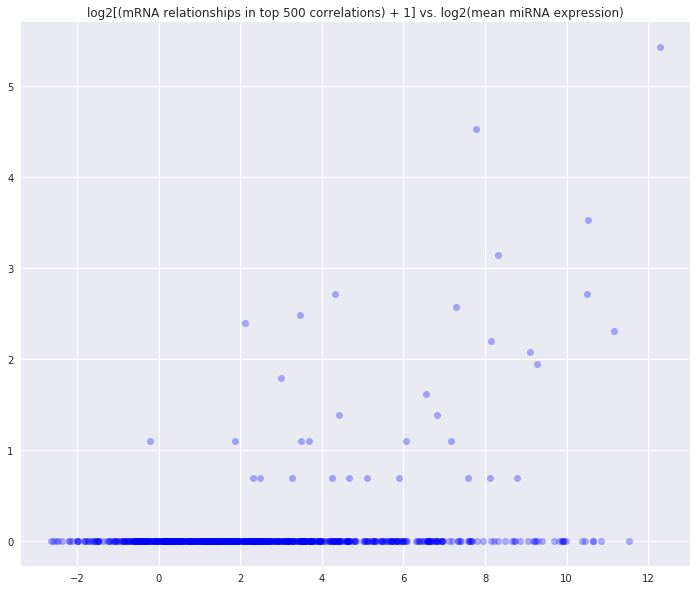

In [303]:
lines = plt.plot(miRNA_means_sorted_log, miRNA_top500corrs_counts.apply(lambda x: m.log(x+1), 2), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('log2[(mRNA relationships in top 500 correlations) + 1] vs. log2(mean miRNA expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q2/log-num-top-500-mRNA-count_vs_log-miRNA-mean.png')

##### Hypergeometric test for enrichment of miRNAs with top-10% mean expression values among top 500 miRNA-mRNA correlation pairs

In [71]:
top10_pctl_start = int(round(miRNA_top500_targets_mask.shape[0] * 0.9))

In [72]:
tenpct_size = miRNA_top500_targets_mask.shape[0] - top10_pctl_start

In [73]:
hypergeom_test_rv = stats.hypergeom(mirtar_corrs.size, tenpct_size * mirtar_corrs.shape[1], 500)

In [74]:
top500corrs_top10pctlmiRNAs_count = miRNA_top500corrs_counts[top10_pctl_start:].sum()
top500corrs_top10pctlmiRNAs_pval = 1 - hypergeom_test_rv.cdf(top500corrs_top10pctlmiRNAs_count)

In [75]:
top500corrs_top10pctlmiRNAs_count

436

In [76]:
top500corrs_top10pctlmiRNAs_pval

1.9113894800248943e-08

In [77]:
mid10_pctl_start = int(round(miRNA_means_sorted_log.size * 0.45))

In [78]:
top500corrs_mid10pctlmiRNAs_count = miRNA_top500corrs_counts[mid10_pctl_start:(mid10_pctl_start+tenpct_size)].sum()
top500corrs_mid10pctlmiRNAs_pval = 1 - hypergeom_test_rv.cdf(top500corrs_mid10pctlmiRNAs_count)

In [94]:
top500corrs_mid10pctlmiRNAs_count

13

In [95]:
top500corrs_mid10pctlmiRNAs_pval

0.9999999998656308

##### Takeaway from above
- This makes clear that most miRNA-mRNA relationships in the top 500 anticorrelations involve miRNAs near the top of the expression distribution
- Thus, plotting CDF of top n negative correlations vs. miRNA expression (measured by mean) is now much less informative

##### miRNA expression and miRNA-target relationships in top 500 correlations (strong miRTarBase relationships and n=1000 [separately] are qualitatively the same thing all over again)

In [80]:
mirtars_in_mirtarbase_mask_sortedby_miRNA_means = mirtars_in_mirtarbase_mask.reindex(miRNA_means_sorted_log.index)

In [81]:
mirtars_in_mirtarbase_and_top500_corrs_mask = mirtars_in_mirtarbase_mask_sortedby_miRNA_means & miRNA_top500_targets_mask

In [82]:
miRNA_top500corr_targets_counts = mirtars_in_mirtarbase_and_top500_corrs_mask.sum(axis=1).apply(lambda x: int(x))

##### Plot log2[(targets in top 500 correlations) + 1] vs. log2(mean miRNA expression)

In [ ]:
lines = plt.plot(miRNA_means_sorted, miRNA_top500corr_targets_counts.apply(lambda x: m.log(x+1), 2), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('log2[(target relationships in top 500 correlations) + 1] vs. log2(mean miRNA expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q2/log-num-top500-target-count_vs_log-miRNA-mean.png')

##### Hypergeometric test for enrichment of miRNA-target pairs with top-10% mean expression values among top 500 miRNA-mRNA correlation pairs

In [83]:
hypergeom_test_rv = stats.hypergeom(mirtar_corrs.size, mirtars_in_mirtarbase_mask_sortedby_miRNA_means.iloc[top10_pctl_start:].sum().sum(), 500)

In [99]:
mirtars_in_mirtarbase_mask_sortedby_miRNA_means.iloc[top10_pctl_start:].sum().sum()

27698

In [84]:
top500corrs_top10pctlmiRNA_targets_count = mirtars_in_mirtarbase_and_top500_corrs_mask.iloc[top10_pctl_start:].sum(axis=1).sum()
top500corrs_top10pctlmiRNA_targets_pval = 1 - hypergeom_test_rv.cdf(top500corrs_top10pctlmiRNA_targets_count)

In [90]:
top500corrs_top10pctlmiRNA_targets_count

21.0

In [86]:
top500corrs_top10pctlmiRNA_targets_pval

0.0

In [91]:
top500corrs_mid10pctlmiRNA_targets_count = mirtars_in_mirtarbase_and_top500_corrs_mask.iloc[mid10_pctl_start:(mid10_pctl_start+tenpct_size)].sum(axis=1).sum()
top500corrs_mid10pctlmiRNA_targets_pval = 1 - hypergeom_test_rv.cdf(top500corrs_mid10pctlmiRNA_targets_count)

In [96]:
top500corrs_mid10pctlmiRNA_targets_count

0.0

In [93]:
top500corrs_mid10pctlmiRNA_targets_pval

0.6809452918951078

##### miRNA expression and (per-miRNA) fraction of targets in top 500 correlations

In [97]:
top500_targets_fraction = miRNA_top500corr_targets_counts / mirtars_in_mirtarbase_mask_sortedby_miRNA_means.sum(axis=1)

##### Plot fraction of targets in top 500 correlations vs. log2(mean miRNA expression)

In [ ]:
lines = plt.plot(miRNA_means_sorted, top500_targets_fraction, 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('fraction of target relationships in top 500 anti-correlation pairs vs. log2(mean miRNA expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q2/targets-fraction-in-top500pairs_vs_log-miRNA-mean.png')

##### Takeaway from above
- Results for strong miRTarBase relationships and n = 1000 (separately) are qualitatively the same damn thing
- I.e. miRTarBase relationships are enriched for highly expressed miRNAs, but fails to capture target (mRNA) relationships more specifically
- Thus we're freed from plotting distributions of % of miRNA miRTarBase targets in top n negative correlations vs. miRNA expression at or above x (measured by mean)

### TODO: Kolmogorov-Smirnov

#### Quantiles (10th, 50th percentiles, mean) vs. miRNA expression (mean, median)
- Kolmogorov-Smirnov test quantile distributions for miRNA expression ranges?
  - e.g. log2 of 8 to 12 vs. 4 to 8

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 44.4 KiB/ 44.4 KiB]                                                
Operation completed over 1 objects/44.4 KiB.                                     


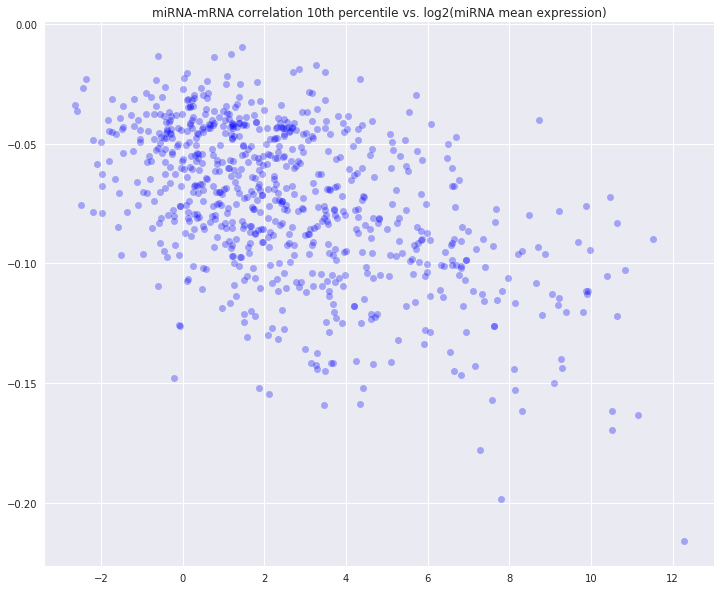

In [100]:
lines = plt.plot(miRNA_means_log, mirtar_corrs.quantile(q=0.1, axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('miRNA-mRNA correlations 10th percentile vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRNAmRNA-corrs-10thpctl_vs_log-miRNA-mean.png')

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 45.6 KiB/ 45.6 KiB]                                                
Operation completed over 1 objects/45.6 KiB.                                     


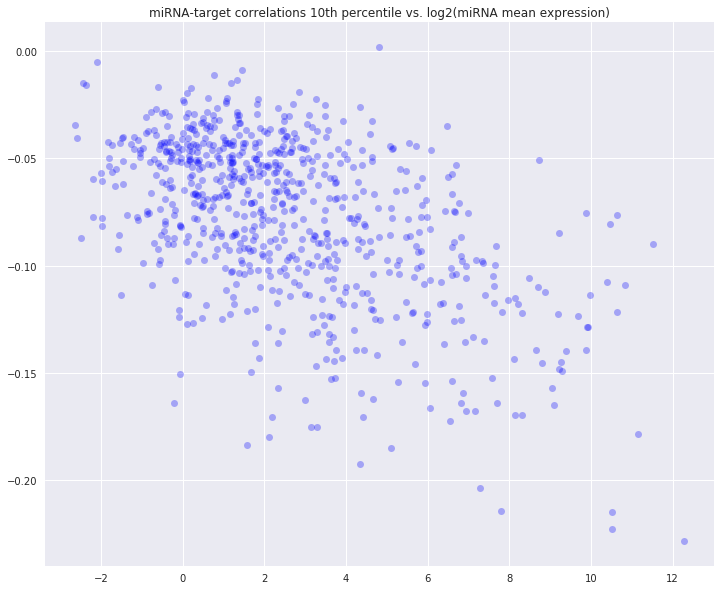

In [101]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_in_mirtarbase_mask).quantile(q=0.1, axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('miRNA-target correlations 10th percentile vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRTar-corrs-10thpctl_vs_log-miRNA-mean.png')

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 42.0 KiB/ 42.0 KiB]                                                
Operation completed over 1 objects/42.0 KiB.                                     


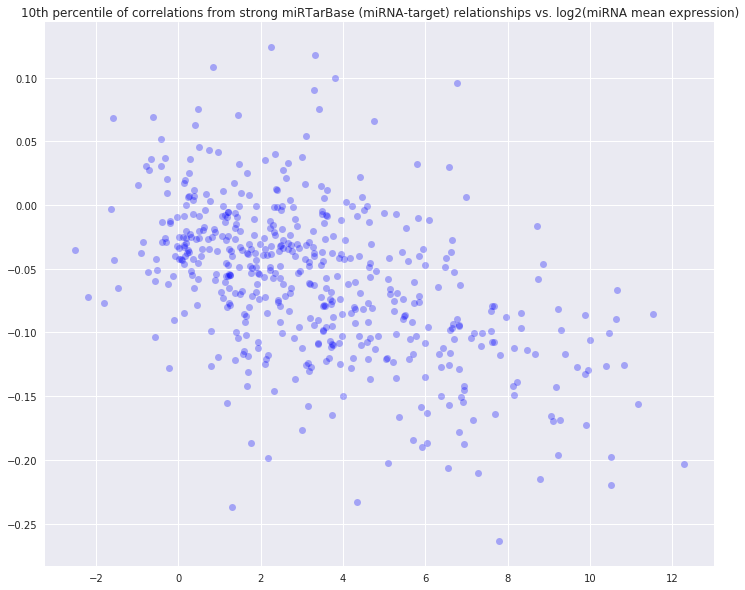

In [102]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_mirtarbase_strong_mask).quantile(q=0.1, axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('10th percentile of correlations from strong miRTarBase (miRNA-target) relationships vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRTar-strong-corrs-10thpctl_vs_log-miRNA-mean.png')

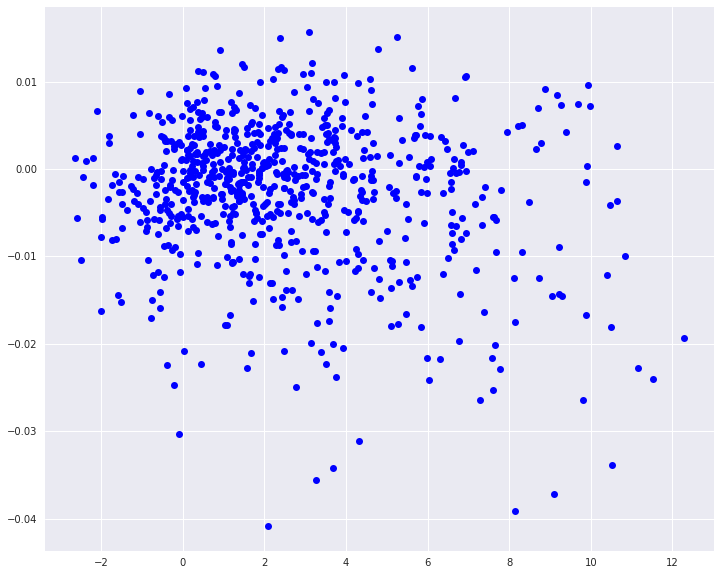

In [73]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.quantile(q=0.5, axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('10th percentile of correlations from strong miRTarBase (miRNA-target) relationships vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRTar-strong-corrs-10thpctl_vs_log-miRNA-mean.png')

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 45.5 KiB/ 45.5 KiB]                                                
Operation completed over 1 objects/45.5 KiB.                                     


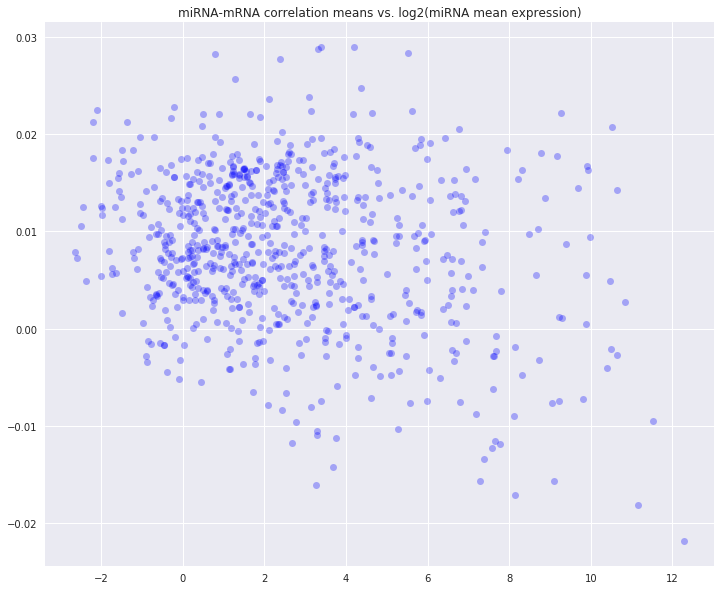

In [103]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.mean(axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('miRNA-mRNA correlation means vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRNAmRNA-corrs-mean_vs_log-miRNA-mean.png')

Copying file://temp.png [Content-Type=image/png]...
/ [1 files][ 45.4 KiB/ 45.4 KiB]                                                
Operation completed over 1 objects/45.4 KiB.                                     


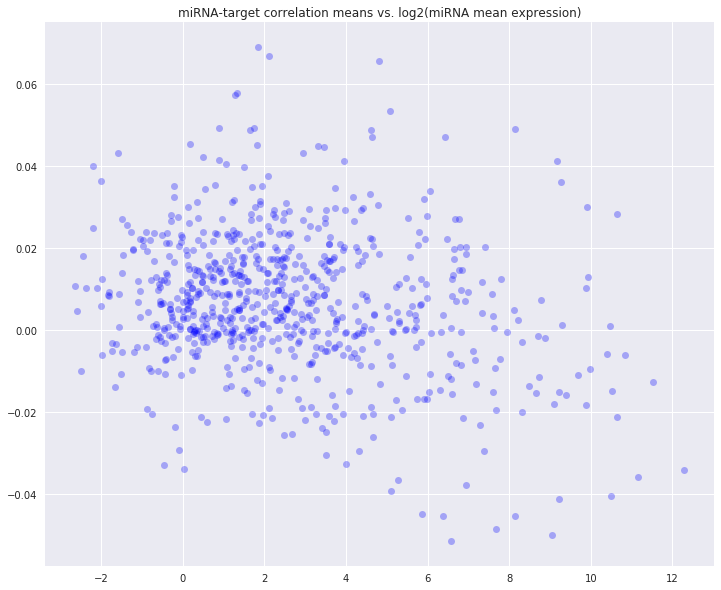

In [104]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_in_mirtarbase_mask).mean(axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
fig.axes[0].set_title('miRNA-target correlation means vs. log2(miRNA mean expression)')
fig.savefig('temp.png')
save_as('temp.png', 'gs://yfl-mirna/analysis/Q3/miRTar-corrs-mean_vs_log-miRNA-mean.png')

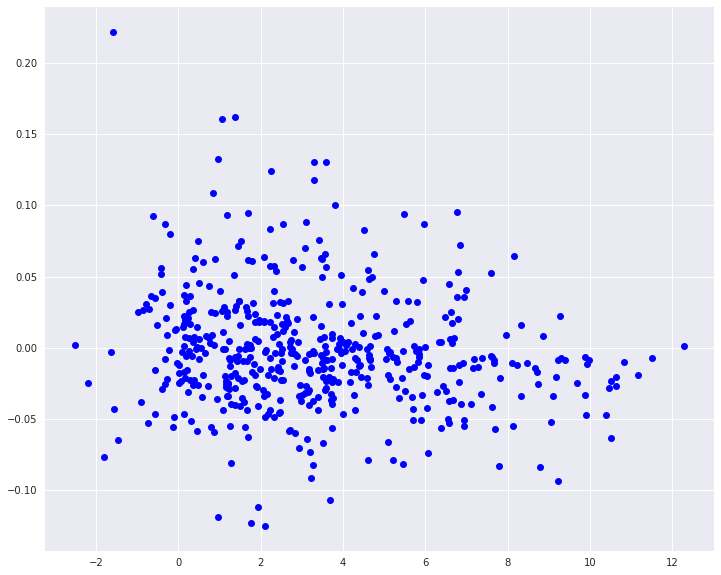

In [97]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_mirtarbase_strong_mask).mean(axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
#fig.axes[0].set_title('distribution per miRNA: log2[(mRNA relationships in top 500) + 1] vs. log2(mean expression)')

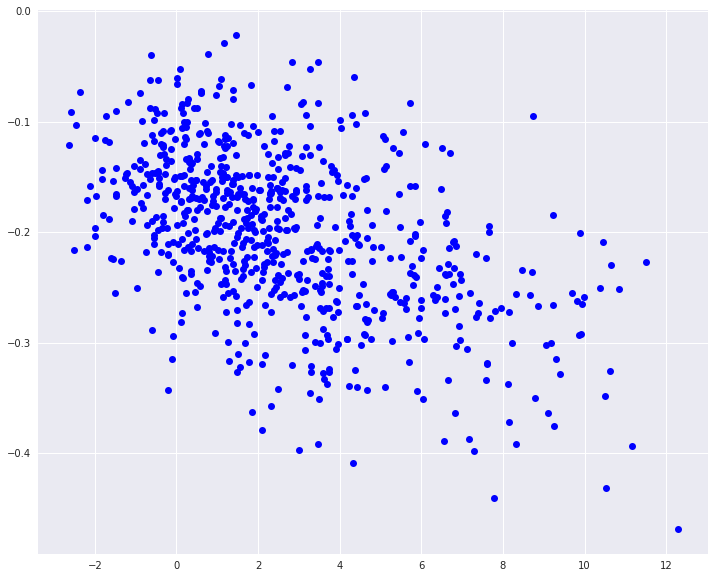

In [74]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.min(axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
#fig.axes[0].set_title('distribution per miRNA: log2[(mRNA relationships in top 500) + 1] vs. log2(mean expression)')

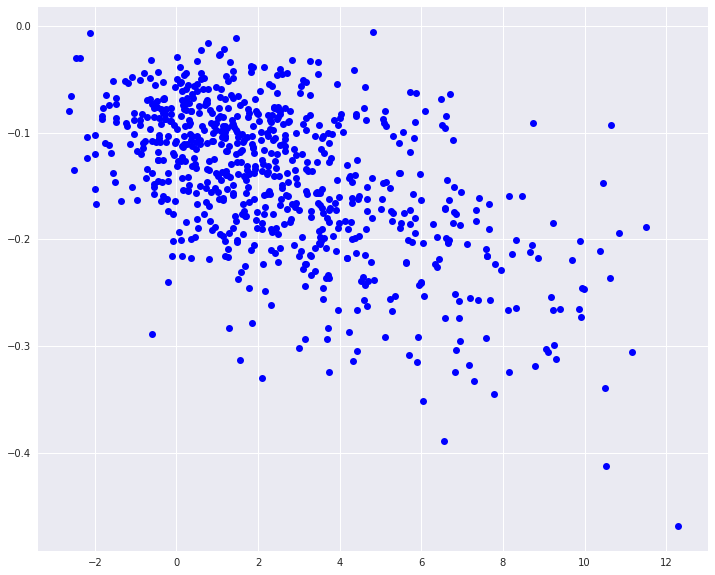

In [98]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_in_mirtarbase_mask).min(axis=1), 'bo', alpha=0.3)
fig = lines[0].figure
fig.set_size_inches(12, 10)
#fig.axes[0].set_title('distribution per miRNA: log2[(mRNA relationships in top 500) + 1] vs. log2(mean expression)')

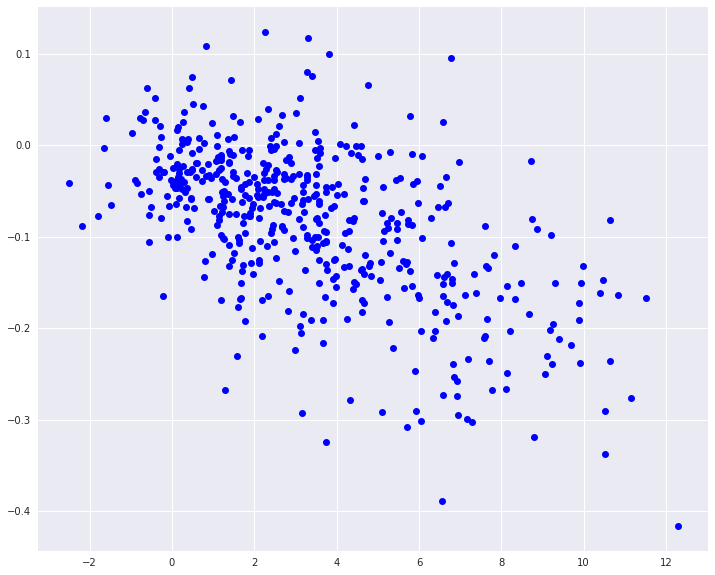

In [99]:
lines = plt.plot(miRNA_data.mean(axis=1).apply(lambda x: m.log(x), 2), mirtar_corrs.where(mirtar_corrs_mirtarbase_strong_mask).min(axis=1), 'bo')
fig = lines[0].figure
fig.set_size_inches(12, 10)
#fig.axes[0].set_title('distribution per miRNA: log2[(mRNA relationships in top 500) + 1] vs. log2(mean expression)')

- Plot distributions of % of miRNA miRTarBase targets in top n negative correlations vs. miRNA expression (measured by mean)
- Plot CDF of top n negative correlations vs. miRNA expression (measured by mean)
- Plot distributions of % of miRNA miRTarBase targets in top n negative correlations vs. miRNA expression at or above x (measured by mean)

### 1. Are pan-cancer correlations dominated/obscured by the locations of within-cancer correlation clouds relative to each other in correlation space?

#### Analysis plan
- Select good examples for contrasting within- vs pan-cancer correlations, by selecting from the following list:
  - For each miRNA-mRNA pair: list, say, 3 most negative within-cancer correlations, with pan-cancer correlation
  - Overlap/otherwise between correlation rankings considering all pairs vs. miRTarBase only

- Largest pan-cancer correlation and within-cancer 10th-percentile correlation: 0.858314473421296, between 'hsa-miR-205-5p' and 79755

In [78]:
miRNAmRNA_within_cancer_corrs = mirtar_spearman_corrs.reset_index().melt(id_vars='miRNA', var_name='mRNA', value_name='PAN').sort_values(['miRNA', 'mRNA'])
miRNAmRNA_within_cancer_corrs = miRNAmRNA_within_cancer_corrs.set_index(['miRNA', 'mRNA'])

In [79]:
for cancer_type in cancer_types:
      mirtar_spearman_corrs = get_corrs_df(bucket, 'explore/miRTar/spearman-corrs/data/mirtar-spearman-corrs_' + cancer_type + '.csv', 'miRNA')
      next = mirtar_spearman_corrs.reset_index().melt(id_vars='miRNA', var_name='mRNA',
                                                      value_name=cancer_type).sort_values(['miRNA', 'mRNA']).set_index(['miRNA', 'mRNA'])
      miRNAmRNA_within_cancer_corrs = miRNAmRNA_within_cancer_corrs.merge(next, how='outer', left_index=True, right_index=True)

In [88]:
miRNAmRNA_within_cancer_corrs['within_cancer_10th_pctl'] = miRNAmRNA_within_cancer_corrs[cancer_types].quantile(0.1, axis=1)
miRNAmRNA_within_cancer_corrs['pancan_within_10th_pctl_diff'] = miRNAmRNA_within_cancer_corrs.PAN - miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl

In [130]:
miRNAmRNA_within_cancer_corrs['within_cancer_median'] = miRNAmRNA_within_cancer_corrs[cancer_types].quantile(0.5, axis=1)

In [131]:
miRNAmRNA_within_cancer_corrs['pancan_within_median_diff'] = miRNAmRNA_within_cancer_corrs.PAN - miRNAmRNA_within_cancer_corrs.within_cancer_median
miRNAmRNA_within_cancer_corrs['within_cancer_mean'] = miRNAmRNA_within_cancer_corrs[cancer_types].mean(axis=1)

In [133]:
miRNAmRNA_within_cancer_corrs['pancan_within_mean_diff'] = miRNAmRNA_within_cancer_corrs.PAN - miRNAmRNA_within_cancer_corrs.within_cancer_mean
miRNAmRNA_within_cancer_corrs.pancan_within_mean_diff.describe()

In [140]:
miRNAmRNA_within_cancer_corrs_flattened_idx = miRNAmRNA_within_cancer_corrs.reset_index()

In [ ]:
miRNAmRNA_within_cancer_corrs['within_cancer_90th_pctl'] = miRNAmRNA_within_cancer_corrs[cancer_types].quantile(0.9, axis=1)
miRNAmRNA_within_cancer_corrs['pancan_within_90th_pctl_diff'] = miRNAmRNA_within_cancer_corrs.PAN - miRNAmRNA_within_cancer_corrs.within_cancer_90th_pctl

In [139]:
miRNAmRNA_within_cancer_corrs.columns

Index([u'PAN', u'ACC', u'BLCA', u'BRCA', u'CESC', u'CHOL', u'COAD', u'DLBC',
       u'ESCA', u'HNSC', u'KICH', u'KIRC', u'KIRP', u'LGG', u'LIHC', u'LUAD',
       u'LUSC', u'MESO', u'OV', u'PAAD', u'PCPG', u'PRAD', u'READ', u'SARC',
       u'SKCM', u'STAD', u'TGCT', u'THCA', u'THYM', u'UCEC', u'UCS', u'UVM',
       u'within_cancer_10th_pctl', u'pancan_within_10th_pctl_diff',
       u'within_cancer_median', u'pancan_within_median_diff',
       u'within_cancer_mean', u'pancan_within_mean_diff'],
      dtype='object')

In [144]:
write_df_to_csv(miRNAmRNA_within_cancer_corrs_flattened_idx, 'idx', 'gs://yfl-mirna/analysis/Q1/miRNAmRNA_within-and-pan-cancer_corrs.csv')



Updates are available for some Cloud SDK components.  To install them,
please run:
  $ gcloud components update

Copying file://temp.csv [Content-Type=text/csv]...
==> NOTE: You are uploading one or more large file(s), which would run          
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

- [1 files][ 10.8 GiB/ 10.8 GiB]   23.7 MiB/s                                   
Operation completed over 1 objects/10.8 GiB.                       

In [ ]:
pancan_withincan_10thpctl_diff = miRNAmRNA_within_cancer_corrs_10th_pctl_lt0.PAN - miRNAmRNA_within_cancer_corrs_10th_pctl_lt0.within_cancer_10th_pctl
pancan_withincan_10thpctl_diff_sorted = pancan_withincan_10thpctl_diff.sort_values()

In [ ]:
miRNAmRNA_within_cancer_corrs_10th_pctl_lt0 = miRNAmRNA_within_cancer_corrs[miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl < 0]

In [128]:
miRNAmRNA_within_cancer_corrs.pancan_within_10th_pctl_diff.describe()

count    1.213690e+07
mean     1.562657e-01
std      1.053115e-01
min     -4.228222e-01
25%      8.585128e-02
50%      1.508635e-01
75%      2.211291e-01
max      8.435325e-01
Name: pancan_within_10th_pctl_diff, dtype: float64

In [126]:
(miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl >= 0).size

15254533

In [ ]:
pancan_withincan_median_diff = 

In [111]:
pancan_withincan_10thpctl_diff_sorted.describe()

count    1.200786e+07
mean     1.557804e-01
std      1.050469e-01
min     -4.228222e-01
25%      8.555985e-02
50%      1.504547e-01
75%      2.205303e-01
max      8.435325e-01
dtype: float64

In [110]:
pancan_withincan_10thpctl_diff_sorted[:10]

miRNA            mRNA 
hsa-miR-205-5p   229     -0.422822
                 6519    -0.413832
hsa-miR-204-3p   4680    -0.386522
hsa-miR-204-5p   4680    -0.376372
hsa-miR-204-3p   9914    -0.376307
hsa-miR-200c-5p  443     -0.363661
hsa-miR-204-3p   57111   -0.362628
hsa-miR-149-5p   9075    -0.353862
hsa-miR-204-3p   2013    -0.350713
hsa-miR-205-5p   51084   -0.346477
dtype: float64

In [117]:
pancan_withincan_10thpctl_diff_sorted[:10].index.labels[0]

FrozenNDArray([216, 216, 214, 215, 214, 210, 214, 135, 214, 216], dtype='int16')

In [118]:
pancan_withincan_10thpctl_diff_sorted[:10].index.levels[0][pancan_withincan_10thpctl_diff_sorted[:10].index.labels[0][0]]

'hsa-miR-205-5p'

In [110]:
pancan_withincan_10thpctl_diff_sorted[:10]

miRNA            mRNA 
hsa-miR-205-5p   229     -0.422822
                 6519    -0.413832
hsa-miR-204-3p   4680    -0.386522
hsa-miR-204-5p   4680    -0.376372
hsa-miR-204-3p   9914    -0.376307
hsa-miR-200c-5p  443     -0.363661
hsa-miR-204-3p   57111   -0.362628
hsa-miR-149-5p   9075    -0.353862
hsa-miR-204-3p   2013    -0.350713
hsa-miR-205-5p   51084   -0.346477
dtype: float64

In [89]:
miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl.describe()

count    1.508877e+07
mean    -1.417221e-01
std      6.898646e-02
min     -6.484587e-01
25%     -1.821068e-01
50%     -1.344027e-01
75%     -9.456267e-02
max      1.000000e+00
Name: within_cancer_10th_pctl, dtype: float64

In [98]:
miRNAmRNA_within_cancer_corrs[cancer_types].mean(axis=1).describe()

count    1.508877e+07
mean     6.101952e-03
std      5.391218e-02
min     -4.103250e-01
25%     -2.411792e-02
50%      4.365738e-03
75%      3.363581e-02
max      1.000000e+00
dtype: float64

In [99]:
miRNAmRNA_within_cancer_corrs['pan-cancer'].describe()

count    1.213690e+07
mean     7.718377e-03
std      1.202430e-01
min     -6.320920e-01
25%     -6.781697e-02
50%      6.273889e-03
75%      8.104180e-02
max      8.674545e-01
Name: pan-cancer, dtype: float64

In [90]:
miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl[miRNAmRNA_within_cancer_corrs.within_cancer_10th_pctl == 1]

miRNA           mRNA     
hsa-miR-767-3p  100124540    1.0
Name: within_cancer_10th_pctl, dtype: float64

In [ ]:
miRNAmRNA_within_cancer_corrs.loc['hsa-miR-767-3p'].loc['100124540']

In [ ]:
pancan_withincan_10thpctl_diff_sorted[pancan_withincan_10thpctl_diff_sorted.notnull()][-1]

In [ ]:
pancan_withincan_10thpctl_diff_sorted[pancan_withincan_10thpctl_diff_sorted.notnull()].index[-1]

## To-do list, working copy

#### Computational

#### Presentational

- Report: Sketch Yep, start working on the report, make an outline, make draft figure, make take-home-messages for the subsections in the Results section and for each of the figures.
- Make links or copies of the Cloud Data Lab notebooks

#### Optional
- Permutation test for miRTar correlations: Compare to how distributions change when data is permuted?

#### Remarks

#2 and/or #3 as inconclusive evidence for #1???
- "#2 and #3 will provide (hopefully conclusive) evidence. #1 will be used for visualization of actual data points (this is important) to give the reader some idea what the conclusive evidence means (sort of), perhaps also where and why it will go wrong (e.g. the pancancer correlations being dominated by tumor types)"

### Nice-to-have FINAL CLEANUP

- rename misleading mirtar vars -> mirmrna
- rename mirtars_in_mirtarbase_mask -> mirmrnas_in_mirtarbase_mask, etc.